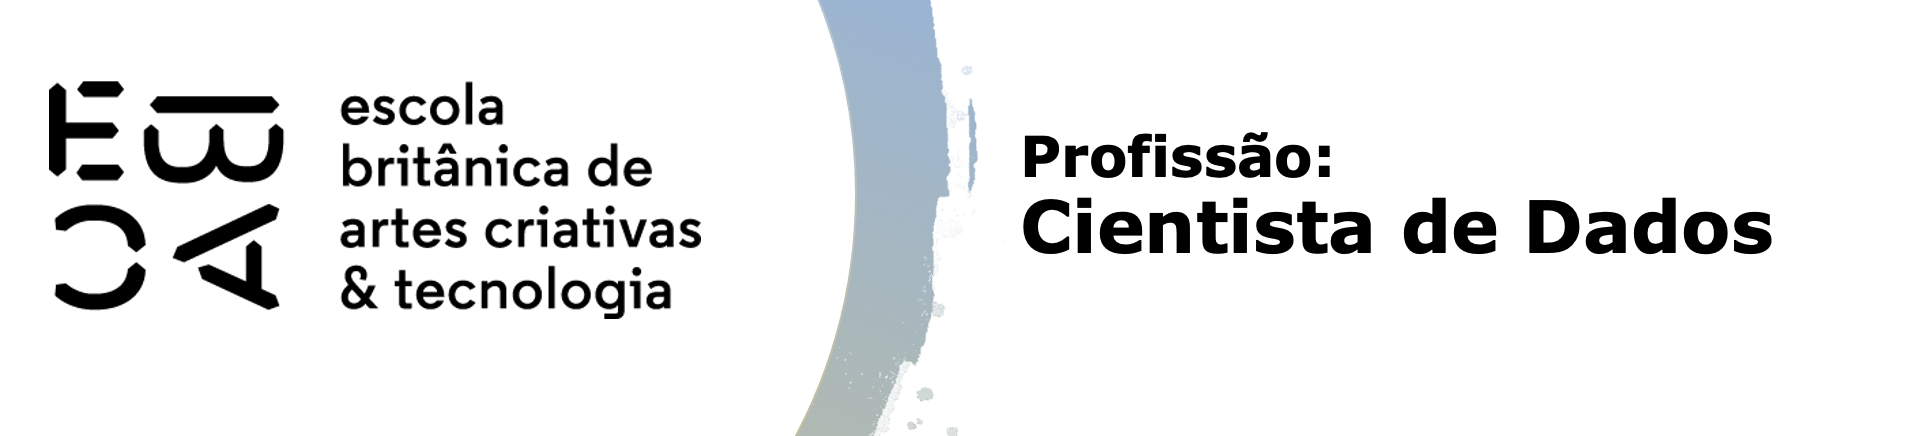

# Módulo 27 - PCA

# Tarefa 02: Classificação de Atividade Humana com PCA

Vamos trabalhar com a base da demonstração feita em aula, mas vamos explorar um pouco melhor como é o desempenho da árvore variando o número de componentes principais.

## 0. Carregamento dos Pacotes e Dados Necessários
Os pacotes utilizados nesta atividade são:
- numpy, para a aplicação de métodos da álgebra linear;
- pandas, para a leitura e ajuste de dados;
- matplotlib.pyplot, para a construção de gráficos;
- seaborn, para a análise estatística gráfica dos ajustes;
- DecisionTreeClassifier do sklearn.tree, para o ajuste de árvores de classificação; 
- PCA do sklearn.decomposition, para a obtenção dos principais componentes de uma base de dados;
- accuracy_score do sklearn.metrics, para o cálculo da acurácia de cada ajuste;
- ConfusionMatrixDisplay do sklearn.metrics, para a visualização da matriz de confusão de cada ajuste.

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

Neste exemplo vamos trabalhar com a base de reconhecimento de atividade humana, disponível no UCI.

In [61]:
# Localiza a tabela com os nomes das variáveis
filename_features = "../Dados/UCI HAR Dataset/features.txt"
filename_labels = "../Dados/UCI HAR Dataset/activity_labels.txt"

# Localiza a tabela com a base de treinamento
filename_subtrain = "../Dados/UCI HAR Dataset/train/subject_train.txt"
filename_xtrain = "../Dados/UCI HAR Dataset/train/X_train.txt"
filename_ytrain = "../Dados/UCI HAR Dataset/train/y_train.txt"

# Localiza a tabela com a base de teste
filename_subtest = "../Dados/UCI HAR Dataset/test/subject_test.txt"
ffilename_xtest = "../Dados/UCI HAR Dataset/test/X_test.txt"
filename_ytest = "../Dados/UCI HAR Dataset/test/y_test.txt"

# Carrega os nomes das variáveis
features = pd.read_csv(filename_features, header=None, names=['nome_var'], squeeze=True, sep="#")
labels = pd.read_csv(filename_labels, delim_whitespace=True, header=None, names=['cod_label', 'label'])

# Carrega a base de treinamento
subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id'], squeeze=True)
X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None, names=features.tolist())
y_train = pd.read_csv(filename_ytrain, header=None, names=['cod_label'])

# Carrega a base de teste
subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id'], squeeze=True)
X_test = pd.read_csv(ffilename_xtest, delim_whitespace=True, header=None, names=features.tolist())
y_test = pd.read_csv(filename_ytest, header=None, names=['cod_label'])

## 1. PCA com variáveis padronizadas

Reflexão sobre a escala das variáveis:

**Variáveis em métricas muito diferentes** podem interferir na análise de componentes principais. Lembra que variância é informação pra nós? Pois bem, tipicamente se há uma variável monetária como salário, vai ter uma ordem de variabilidade bem maior que número de filhos, tempo de emprego ou qualquer variável dummy. Assim, as variáveis de maior variância tendem a "dominar" a análise. Nesses casos é comum usar a padronização das variáveis.

Faça duas análises de componentes principais para a base do HAR - com e sem padronização e compare:

- A variância explicada por componente
- A variância explicada acumulada por componente
- A variância percentual por componente
- A variância percentual acumulada por componente
- Quantas componentes você escolheria, em cada caso para explicar 90% da variância?

> Vamos começar o exercício padronizando a base do HAR, para isso, vamos utilizar a função padroniza(_s_), que recebe um vetor (ou lista) _s_ e a padroniza de acordo com a equação:
>
> # $$ s_{pad} = \frac{s - \bar{s}}{\sigma_{s}} $$
>
> onde: 
>
> - $\bar{s}$ é o valor médio de _s_,
> - $\sigma_{s}$ é o desvio padrão de _s_.
>
> A partir desta função serão padronizadas as bases de treino e teste.

In [62]:
# Função de padronização de uma variável
def padroniza(s):
    if s.std() > 0:
        s = (s - s.mean())/s.std()
    return s

In [63]:
%%time

# Padroniza toda a base de treino 
X_train_pad = pd.DataFrame(X_train).apply(padroniza, axis=0)
X_train_pad.head()

Wall time: 241 ms


,1 tBodyAcc-mean()-X,2 tBodyAcc-mean()-Y,3 tBodyAcc-mean()-Z,4 tBodyAcc-std()-X,5 tBodyAcc-std()-Y,6 tBodyAcc-std()-Z,7 tBodyAcc-mad()-X,8 tBodyAcc-mad()-Y,9 tBodyAcc-mad()-Z,10 tBodyAcc-max()-X,...,552 fBodyBodyGyroJerkMag-meanFreq(),553 fBodyBodyGyroJerkMag-skewness(),554 fBodyBodyGyroJerkMag-kurtosis(),"555 angle(tBodyAccMean,gravity)","556 angle(tBodyAccJerkMean),gravityMean)","557 angle(tBodyGyroMean,gravityMean)","558 angle(tBodyGyroJerkMean,gravityMean)","559 angle(X,gravityMean)","560 angle(Y,gravityMean)","561 angle(Z,gravityMean)"
0,0.200628,-0.063678,-0.419600,-0.868755,-0.939377,-0.737479,-0.859758,-0.938955,-0.766385,-0.855978,...,-0.795305,0.025958,-0.276380,-0.360579,0.062935,-0.778374,-0.026079,-0.687172,0.407918,-0.007567
1,0.055944,0.031484,-0.253891,-0.875366,-0.923839,-0.849247,-0.868472,-0.921936,-0.848870,-0.871300,...,0.130605,-0.897296,-0.767938,0.133002,-0.021460,-1.218722,1.484369,-0.694091,0.409089,0.007875
2,0.073510,-0.043414,-0.076289,-0.868980,-0.907698,-0.893724,-0.863078,-0.898793,-0.896640,-0.863264,...,1.152257,-0.260860,-0.438286,-0.377815,0.391949,0.151197,1.704085,-0.702191,0.410260,0.026501
3,0.066691,-0.208407,-0.249695,-0.870566,-0.939959,-0.921743,-0.864445,-0.938060,-0.925216,-0.863264,...,1.112694,0.591005,0.463123,-0.135016,-0.033635,1.037781,-1.002951,-0.701636,0.414622,0.031712
4,0.030467,0.027585,-0.109840,-0.875128,-0.934815,-0.921281,-0.867325,-0.931726,-0.927965,-0.870201,...,-0.149567,-0.138505,-0.240296,0.340383,0.268468,1.125841,-1.276196,-0.700104,0.425434,0.045222


In [64]:
%%time

# Padroniza toda a base de teste
X_test_pad = pd.DataFrame(X_test).apply(padroniza, axis=0)
X_test_pad.head()

Wall time: 227 ms


,1 tBodyAcc-mean()-X,2 tBodyAcc-mean()-Y,3 tBodyAcc-mean()-Z,4 tBodyAcc-std()-X,5 tBodyAcc-std()-Y,6 tBodyAcc-std()-Z,7 tBodyAcc-mad()-X,8 tBodyAcc-mad()-Y,9 tBodyAcc-mad()-Z,10 tBodyAcc-max()-X,...,552 fBodyBodyGyroJerkMag-meanFreq(),553 fBodyBodyGyroJerkMag-skewness(),554 fBodyBodyGyroJerkMag-kurtosis(),"555 angle(tBodyAccMean,gravity)","556 angle(tBodyAccJerkMean),gravityMean)","557 angle(tBodyGyroMean,gravityMean)","558 angle(tBodyGyroJerkMean,gravityMean)","559 angle(X,gravityMean)","560 angle(Y,gravityMean)","561 angle(Z,gravityMean)"
0,-0.277661,-0.210595,2.192704,-0.787134,-0.833071,-0.093428,-0.807954,-0.838871,-0.104160,-0.824606,...,-0.253620,-0.166362,-0.344707,0.003565,0.357512,-1.363669,0.575389,-0.404722,0.622618,-0.038342
1,0.198626,0.182560,-0.250221,-0.876836,-0.928903,-0.857905,-0.896993,-0.928791,-0.863122,-0.824606,...,-2.300359,0.490938,0.012254,-0.264048,0.030782,-0.747105,1.870875,-0.361677,0.636623,-0.145684
2,0.024583,-0.318001,-0.228446,-0.921442,-0.933896,-0.906953,-0.916735,-0.933654,-0.912484,-0.910827,...,-0.291514,0.274775,-0.134966,-0.119651,0.445996,0.037913,0.323883,-0.370869,0.632738,-0.126834
3,-0.061047,-0.572940,-0.213673,-0.923681,-0.940657,-0.918926,-0.918996,-0.941439,-0.927619,-0.909586,...,-0.058615,-0.210642,-0.441639,-0.066432,0.338455,0.472614,0.625768,-0.363372,0.645167,-0.117565
4,0.013820,-0.387815,-0.494555,-0.921523,-0.928878,-0.949818,-0.915977,-0.923689,-0.951235,-0.909586,...,-1.090596,-0.810389,-0.796804,-0.022272,-0.098513,1.097162,-0.201965,-0.350197,0.665544,-0.104100


### 1.1 PCA da Base HAR não padronizada
>Primeiramente, vamos aplicar o método PCA na base HAR não padronizada.

In [65]:
%%time

# Submete toda a base de treino ao método PCA
prcomp = PCA().fit(X_train)

# Obtém todas as Componentes Prinicipais na base de treino
pc_treino = prcomp.transform(X_train)

# Obtém todas as Componentes Prinicipais na base de teste
pc_teste = prcomp.transform(X_test)

print(f'Há {pc_treino.shape[1]} principais componentes em cada base.')

Há 561 principais componentes em cada base.
Wall time: 448 ms


> Agora que foram obtidas todas as principais componentes de cada base, vamos transformá-las em dataframes.

In [66]:
# Número de CP (Componentes Principais) analisadas
n = pc_treino.shape[1]

# Cria uma lista com os números das CP
colunas = ['cp'+str(x+1) for x in list(range(n))]

# Faz um dataframe do PCA na base de treino
pc_train = pd.DataFrame(pc_treino[:,:n], columns = colunas)

# Faz um dataframe do PCA na base de teste
pc_test  = pd.DataFrame(pc_teste[:,:n], columns = colunas)

# Mostra as 5 primeiras linhas do dataframe
pc_train.head()

,cp1,cp2,cp3,cp4,cp5,cp6,cp7,cp8,cp9,cp10,...,cp552,cp553,cp554,cp555,cp556,cp557,cp558,cp559,cp560,cp561
0,-5.520280,-0.290278,-1.529929,1.333242,1.425089,-0.194708,0.577454,0.691490,-1.222865,-0.363414,...,9.079626e-18,5.205236e-17,9.232218e-17,1.829357e-17,-5.135641e-17,-9.097983e-16,1.579485e-16,-1.913386e-16,2.566481e-16,1.204706e-16
1,-5.535350,-0.082530,-1.924804,0.671273,0.671260,0.735144,-0.616908,-0.771714,-0.615496,-0.895525,...,1.175244e-16,-8.117808e-17,4.688354e-17,7.039252e-18,1.049099e-16,3.329999e-16,6.684782e-17,2.940125e-16,3.424757e-16,5.641906e-17
2,-5.474988,0.287387,-2.144642,0.531806,0.207824,-0.037772,0.057628,0.093917,-0.063147,-0.216898,...,4.840573e-17,-1.969871e-17,-5.934388e-17,-6.007923e-17,6.817021e-17,-8.132565e-16,6.832346e-17,-9.886586e-17,4.180205e-17,8.893729e-17
3,-5.677232,0.897031,-2.018220,0.157125,0.759085,1.079547,-0.267805,-0.731391,0.281296,0.466269,...,4.410679e-17,-6.684714e-17,6.981143e-17,-2.299512e-17,3.473939e-17,2.963450e-16,7.805055e-17,-1.586568e-17,-1.422579e-16,-1.183803e-16
4,-5.748749,1.162952,-2.139533,0.207823,0.473090,0.463035,-0.152227,-0.107509,0.289819,0.539206,...,1.982681e-17,-4.291827e-17,5.019921e-17,-9.967968e-17,6.122569e-17,1.211954e-16,8.007437e-17,8.599373e-17,6.674067e-16,2.230873e-17


> Dado que os dataframes estão prontos, vejamos gráficamente (na base de treino)
> - A variância explicada por componente
> - A variância explicada acumulada por componente
> - A variância percentual por componente
> - A variância percentual acumulada por componente
> - A quantidade de componentes necessárias para explicar 90% da variância

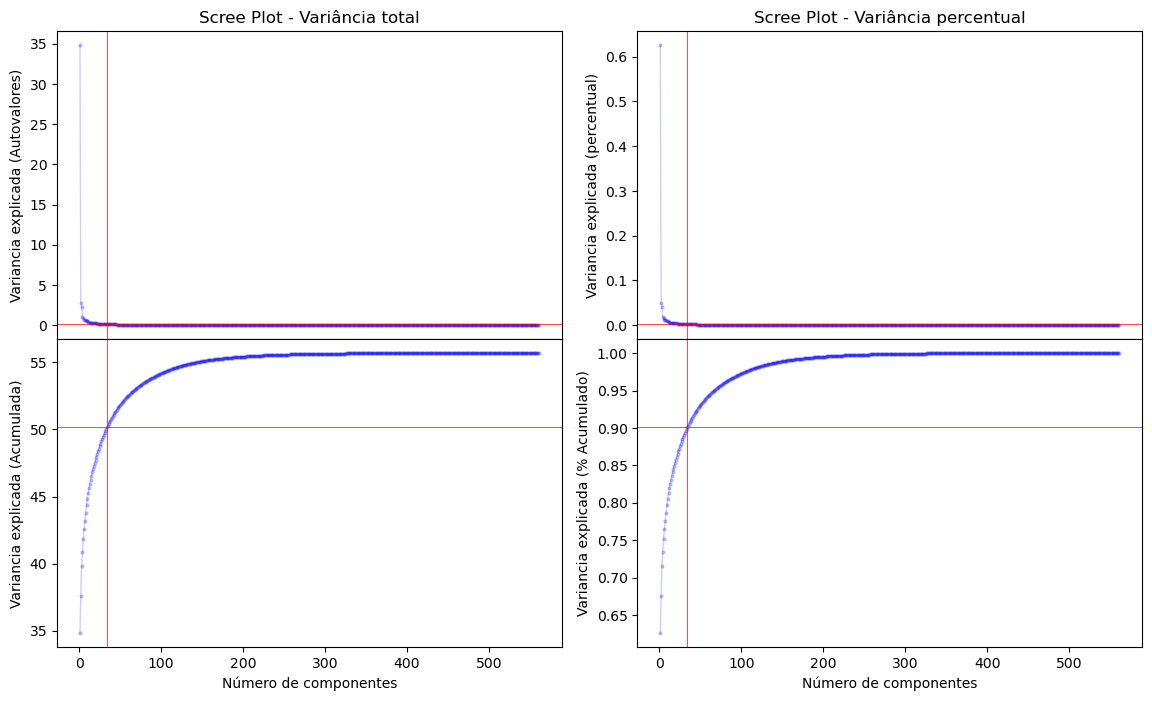

In [67]:
# Cria a figura na qual vão ser inseridos os 4 gráficos
fig, ax = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)

# Número de componentes que explicam 90% da variância 
varexplicada = .90
ncomp_crit = (prcomp.explained_variance_ratio_.cumsum()<varexplicada).sum()+1


#Gráfico da variância nominal por qtd-componentes
num_componentes = np.arange(prcomp.n_components_) + 1
ax[0,0].plot(num_componentes, prcomp.explained_variance_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0,0].set_title('Scree Plot - Variância total')
ax[0,0].set_xlabel('Número de componentes')
ax[0,0].set_ylabel('Variancia explicada (Autovalores)')

#Gráfico da variância nominal acumulada por qtd-componentes
ax[1,0].plot(num_componentes, prcomp.explained_variance_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1,0].set_xlabel('Número de componentes')
ax[1,0].set_ylabel('Variancia explicada (Acumulada)')

#Gráfico da variância percentual por qtd-componentes
ax[0,1].plot(num_componentes, prcomp.explained_variance_ratio_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0,1].set_title('Scree Plot - Variância percentual')
ax[0,1].set_xlabel('Número de componentes')
ax[0,1].set_ylabel('Variancia explicada (percentual)')

#Gráfico da variância percentual acumulada por qtd-componentes
ax[1,1].plot(num_componentes, prcomp.explained_variance_ratio_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1,1].set_xlabel('Número de componentes')
ax[1,1].set_ylabel('Variancia explicada (% Acumulado)')

# linhas verticais de referência
ax[0,0].axvline(x = ncomp_crit, color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axvline(x = ncomp_crit, color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axvline(x = ncomp_crit, color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axvline(x = ncomp_crit, color = 'r', linestyle = '-', linewidth=.5)

# linhas horizontais
ncomp_criterio2 = 50
ax[0,0].axhline(y = prcomp.explained_variance_[ncomp_crit-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axhline(y = prcomp.explained_variance_.cumsum()[ncomp_crit-1], color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axhline(y = prcomp.explained_variance_ratio_[ncomp_crit-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axhline(y = prcomp.explained_variance_ratio_.cumsum()[ncomp_crit-1], color = 'r', linestyle = '-', linewidth=.5)

plt.show()

> A quantidade de variáveis necessárias para explicar 90% da variância encontra-se no na coluna vermelha do último gráfico (esquerda inferior) no eixo x. Visualizando o gráfico, nota-se que o valor está entre 0 e 100, sendo inferior a 50. Para obter a quantidade exata, vamos imprimir os valores presentes em cada gráfico.

In [68]:
variancia               = prcomp.explained_variance_[ncomp_crit-1]
variancia_acumulada     = prcomp.explained_variance_.cumsum()[ncomp_crit-1]
pct_variancia           = prcomp.explained_variance_ratio_[ncomp_crit-1]
pct_variancia_acumulada = prcomp.explained_variance_ratio_.cumsum()[ncomp_crit-1]

print(f'Número de componentes:............... {ncomp_crit}')
print(f'Variância da ultima CP:.............. {variancia:.2f}' )
print(f'Variância total explicada:........... {variancia_acumulada:.2f}' )
print(f'Variância percentual da última CP:... {100*pct_variancia:.2f}%' )
print(f'Variância percentual total explicada: {100*pct_variancia_acumulada:.2f}%' )

Número de componentes:............... 34
Variância da ultima CP:.............. 0.13
Variância total explicada:........... 50.15
Variância percentual da última CP:... 0.24%
Variância percentual total explicada: 90.09%


### 1.2 PCA da Base HAR padronizada 
> Nesta segunda parte do exercício, vamos repetir todo o procedimento anterior, mas na base de treino padronizada.

In [69]:
%%time

# Submete toda a base de treino padronizada ao método PCA
prcomp_pad = PCA().fit(X_train_pad)

# Obtém todas as Componentes Prinicipais na base de treino padronizada
pc_treino_pad = prcomp_pad.transform(X_train_pad)

# Obtém todas as Componentes Prinicipais na base de teste padronizada
pc_teste_pad = prcomp_pad.transform(X_test_pad)

print(f'Há {pc_treino_pad.shape[1]} principais componentes em cada base.')

Há 561 principais componentes em cada base.
Wall time: 419 ms


In [70]:
# Número de CP (Componentes Principais) analisadas
n = pc_treino_pad.shape[1]

# Cria uma lista com os números das CP
colunas = ['cp'+str(x+1) for x in list(range(n))]

# Faz um dataframe do PCA na base de treino padronizada
pc_train_pad = pd.DataFrame(pc_treino_pad[:,:n], columns = colunas)

# Faz um dataframe do PCA na base de teste padronizada
pc_test_pad = pd.DataFrame(pc_teste_pad[:,:n], columns = colunas)

# Mostra as 5 primeiras linhas do dataframe
pc_train_pad.head()

,cp1,cp2,cp3,cp4,cp5,cp6,cp7,cp8,cp9,cp10,...,cp552,cp553,cp554,cp555,cp556,cp557,cp558,cp559,cp560,cp561
0,-16.137446,2.151878,3.144566,-0.272446,6.798476,-4.249105,2.936959,-4.905079,-0.775462,-3.627490,...,-2.403518e-16,7.496678e-17,-4.225384e-16,2.564611e-16,-1.031234e-16,-2.496687e-16,-6.684645e-17,-1.224606e-16,2.982603e-15,-2.083066e-16
1,-15.295154,1.387049,-0.682175,2.813486,4.265880,-2.055523,0.011204,-1.845860,0.492513,-0.180162,...,-3.154596e-16,1.565630e-16,-2.280563e-16,-5.526286e-17,1.916194e-16,-2.294591e-16,6.147755e-16,-2.964085e-16,-2.307035e-16,-3.135995e-16
2,-15.135989,2.473183,-1.756521,3.717722,4.181273,-1.357425,0.072942,-1.388094,0.539717,-0.671666,...,-3.422253e-16,8.638424e-17,-7.017672e-18,8.064107e-17,4.253274e-16,2.168809e-16,1.889049e-16,-1.291810e-16,-3.162297e-15,-2.358138e-16
3,-15.349840,3.915414,-1.790201,2.567347,3.205621,-0.942880,0.530700,-1.832060,1.071444,-1.496887,...,2.448101e-16,1.171110e-16,-2.242103e-16,2.243426e-16,1.625606e-16,-3.674953e-16,-1.376078e-16,-3.826154e-16,1.034254e-16,6.201240e-16
4,-15.543756,4.598424,-2.188433,2.897381,3.079941,-1.061386,-1.048520,-0.816877,0.600022,1.118799,...,-2.510114e-16,2.119385e-16,-4.793935e-16,3.353967e-17,-4.008359e-17,-4.131518e-16,7.587954e-16,-6.338356e-16,-2.944255e-15,-2.257888e-16


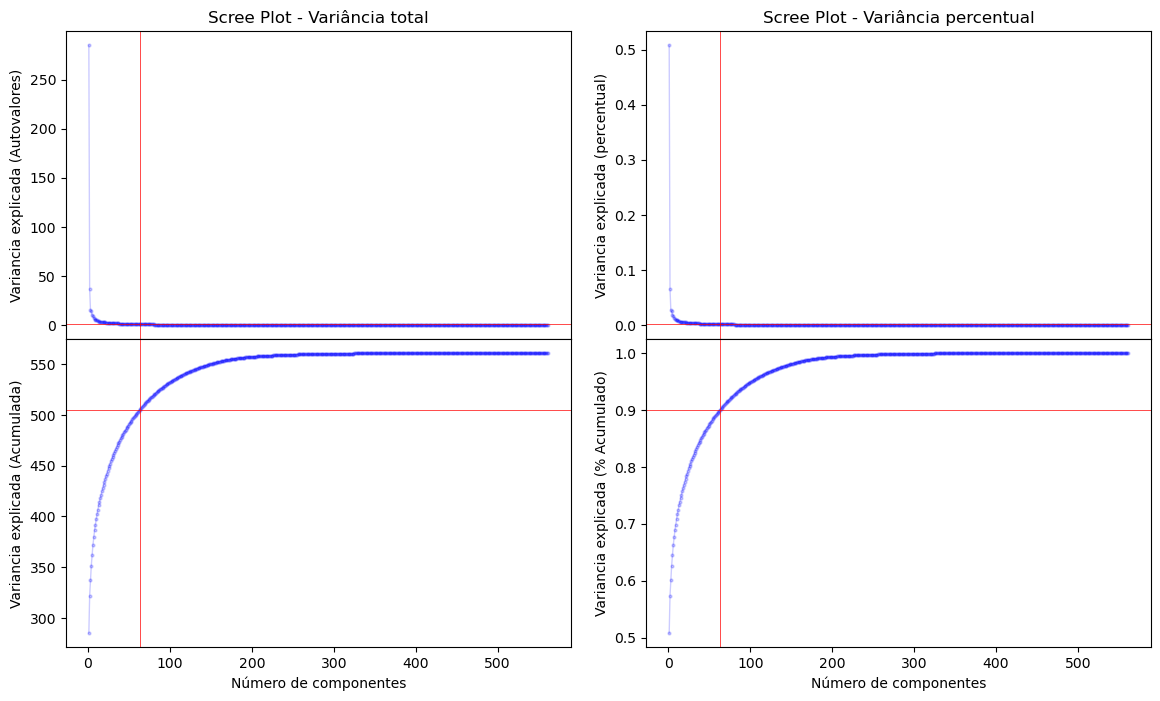

In [71]:
# Cria a figura na qual vão ser inseridos os 4 gráficos
fig, ax = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)

# Número de componentes que explicam 90% da variância 
varexplicada = .90
ncomp_crit_pad = (prcomp_pad.explained_variance_ratio_.cumsum()<varexplicada).sum()+1


#Gráfico da variância nominal por qtd-componentes
num_componentes = np.arange(prcomp_pad.n_components_) + 1
ax[0,0].plot(num_componentes, prcomp_pad.explained_variance_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0,0].set_title('Scree Plot - Variância total')
ax[0,0].set_xlabel('Número de componentes')
ax[0,0].set_ylabel('Variancia explicada (Autovalores)')

#Gráfico da variância nominal acumulada por qtd-componentes
ax[1,0].plot(num_componentes, prcomp_pad.explained_variance_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1,0].set_xlabel('Número de componentes')
ax[1,0].set_ylabel('Variancia explicada (Acumulada)')

#Gráfico da variância percentual por qtd-componentes
ax[0,1].plot(num_componentes, prcomp_pad.explained_variance_ratio_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0,1].set_title('Scree Plot - Variância percentual')
ax[0,1].set_xlabel('Número de componentes')
ax[0,1].set_ylabel('Variancia explicada (percentual)')

#Gráfico da variância percentual acumulada por qtd-componentes
ax[1,1].plot(num_componentes, prcomp_pad.explained_variance_ratio_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1,1].set_xlabel('Número de componentes')
ax[1,1].set_ylabel('Variancia explicada (% Acumulado)')

# linhas verticais de referência
ax[0,0].axvline(x = ncomp_crit_pad, color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axvline(x = ncomp_crit_pad, color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axvline(x = ncomp_crit_pad, color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axvline(x = ncomp_crit_pad, color = 'r', linestyle = '-', linewidth=.5)

# linhas horizontais
ncomp_criterio2 = 50
ax[0,0].axhline(y = prcomp_pad.explained_variance_[ncomp_crit_pad-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axhline(y = prcomp_pad.explained_variance_.cumsum()[ncomp_crit_pad-1], color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axhline(y = prcomp_pad.explained_variance_ratio_[ncomp_crit_pad-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axhline(y = prcomp_pad.explained_variance_ratio_.cumsum()[ncomp_crit_pad-1], color = 'r', linestyle = '-', linewidth=.5)

plt.show()

In [72]:
variancia               = prcomp_pad.explained_variance_[ncomp_crit_pad-1]
variancia_acumulada     = prcomp_pad.explained_variance_.cumsum()[ncomp_crit_pad-1]
pct_variancia           = prcomp_pad.explained_variance_ratio_[ncomp_crit_pad-1]
pct_variancia_acumulada = prcomp_pad.explained_variance_ratio_.cumsum()[ncomp_crit_pad-1]

print(f'Número de componentes:............... {ncomp_crit_pad}')
print(f'Variância da ultima CP:.............. {variancia:.2f}' )
print(f'Variância total explicada:........... {variancia_acumulada:.2f}' )
print(f'Variância percentual da última CP:... {100*pct_variancia:.2f}%' )
print(f'Variância percentual total explicada: {100*pct_variancia_acumulada:.2f}%' )

Número de componentes:............... 63
Variância da ultima CP:.............. 0.99
Variância total explicada:........... 505.20
Variância percentual da última CP:... 0.18%
Variância percentual total explicada: 90.05%


### 1.3 Comparação entre os resultados

> Visualizando os resultados de ambas as bases, são notadas duas diferenças significativas:
> - A quantidade de informação presente na base padronizada é, aproximandamente, 10 vezes maior do que a da base não padronizada, tal como pode ser visualizado na linha "Variância total explicada"; 
>
> - Uma vez que o total de informação é maior, a quantidade de principais componentes necessárias para explicar 90% da variância também é maior. Enquanto que na base não padronizada são necessárias 34 CP, na padronizada precisam-se de 63 (quase o dobro).

## 2. Árvore com PCA

Faça duas uma árvore de decisão com 10 componentes principais - uma com base em dados padronizados e outra sem padronizar. Utilize o ```ccp_alpha=0.001```.

Compare a acurácia na base de treino e teste.

### 2.1 Árvore na base não padronizada

In [73]:
# Seleciona as 10 primeiras colunas da base de treino não padronizada
pc_train10 = pc_train.iloc[:, :10]

# Seleciona as 10 primeiras colunas da base de teste não padronizada
pc_test10 = pc_test.iloc[:, :10]

# Mostra as colunas selecionadas da base de treino
pc_train10

,cp1,cp2,cp3,cp4,cp5,cp6,cp7,cp8,cp9,cp10
0,-5.520280,-0.290278,-1.529929,1.333242,1.425089,-0.194708,0.577454,0.691490,-1.222865,-0.363414
1,-5.535350,-0.082530,-1.924804,0.671273,0.671260,0.735144,-0.616908,-0.771714,-0.615496,-0.895525
2,-5.474988,0.287387,-2.144642,0.531806,0.207824,-0.037772,0.057628,0.093917,-0.063147,-0.216898
3,-5.677232,0.897031,-2.018220,0.157125,0.759085,1.079547,-0.267805,-0.731391,0.281296,0.466269
4,-5.748749,1.162952,-2.139533,0.207823,0.473090,0.463035,-0.152227,-0.107509,0.289819,0.539206
...,...,...,...,...,...,...,...,...,...,...
7347,6.253517,-2.636767,0.448229,1.476516,-0.767298,-0.268023,-1.348600,-0.463529,1.463389,0.210285
7348,5.782321,-2.437814,0.462731,1.711345,-0.825446,-0.403852,-1.257430,-0.319120,0.424317,-0.814650
7349,5.857505,-3.081843,0.671207,2.253646,-0.494577,0.391518,-1.000016,-0.162912,0.291533,1.248849
7350,5.421095,-3.426430,0.671243,2.013981,-0.612601,0.443119,-1.445597,-0.112817,0.813037,1.681171


In [74]:
%%time

# Cria a árvore com todas as variáveis e ccp_alpha=0.001 na base de treinamento
clf = DecisionTreeClassifier(random_state=42, ccp_alpha=0.001).fit(pc_train10, y_train)

Wall time: 85.7 ms


In [75]:
# Mede a acurácia na base de treinamento
acc_train = clf.score(pc_train10, y_train) 

# Mede a acurácia na base de teste
acc_test = clf.score(pc_test10, y_test) 

# Imprime os resultados
print(f'Acurácia da árvore com 10 CPs na base de treinamento não padronizada: {acc_train*100:.2f}%.')
print(f'Acurácia da árvore com 10 CPs na base de teste não padronizada: {acc_test*100:.2f}%.')

Acurácia da árvore com 10 CPs na base de treinamento não padronizada: 89.27%.
Acurácia da árvore com 10 CPs na base de teste não padronizada: 82.42%.


### 2.2 Árvore na base padronizada

In [76]:
# Seleciona as 10 primeiras colunas da base de treino padronizada
pc_train_pad10 = pc_train_pad.iloc[:, :10]

# Seleciona as 10 primeiras colunas da base de teste padronizada
pc_test_pad10 = pc_test_pad.iloc[:, :10]

# Mostra as colunas selecionadas da base de treino padronizada
pc_train_pad10

,cp1,cp2,cp3,cp4,cp5,cp6,cp7,cp8,cp9,cp10
0,-16.137446,2.151878,3.144566,-0.272446,6.798476,-4.249105,2.936959,-4.905079,-0.775462,-3.627490
1,-15.295154,1.387049,-0.682175,2.813486,4.265880,-2.055523,0.011204,-1.845860,0.492513,-0.180162
2,-15.135989,2.473183,-1.756521,3.717722,4.181273,-1.357425,0.072942,-1.388094,0.539717,-0.671666
3,-15.349840,3.915414,-1.790201,2.567347,3.205621,-0.942880,0.530700,-1.832060,1.071444,-1.496887
4,-15.543756,4.598424,-2.188433,2.897381,3.079941,-1.061386,-1.048520,-0.816877,0.600022,1.118799
...,...,...,...,...,...,...,...,...,...,...
7347,15.464009,-12.535453,1.999041,3.457489,-1.523091,-2.698944,-3.561009,2.418529,0.383154,1.308633
7348,14.221755,-10.252804,2.377499,2.802476,-1.325223,-4.345821,-2.193817,0.032138,-0.528893,0.702462
7349,14.332461,-12.259878,4.025672,3.849518,-2.860295,-3.623803,-3.929374,-0.873103,-0.746280,-1.575419
7350,12.875143,-14.070299,2.915863,5.013085,-3.937957,-2.137461,-5.390033,0.321283,-0.916237,-1.646259


In [77]:
%%time

# Cria a árvore com todas as variáveis e ccp_alpha=0.001 na base de treinamento padronizada
clf_pad = DecisionTreeClassifier(random_state=42, ccp_alpha=0.001).fit(pc_train_pad10, y_train)

Wall time: 84 ms


In [78]:
# Mede a acurácia na base de treinamento padronizada
acc_train_pad = clf_pad.score(pc_train_pad10, y_train) 

# Mede a acurácia na base de teste padronizada
acc_test_pad = clf_pad.score(pc_test_pad10, y_test) 

# Imprime os resultados
print(f'Acurácia da árvore com 10 CPs na base de treinamento padronizada: {acc_train_pad*100:.2f}%.')
print(f'Acurácia da árvore com 10 CPs na base de teste padronizada: {acc_test_pad*100:.2f}%.')

Acurácia da árvore com 10 CPs na base de treinamento padronizada: 85.87%.
Acurácia da árvore com 10 CPs na base de teste padronizada: 77.37%.


### 2.3 Comparação entre os ajustes pelas Matrizes de Confusão
> Para ter uma melhor comparação entre as acurácias das bases de teste em cada caso, vejamos a matriz de comparação de cada ajuste.

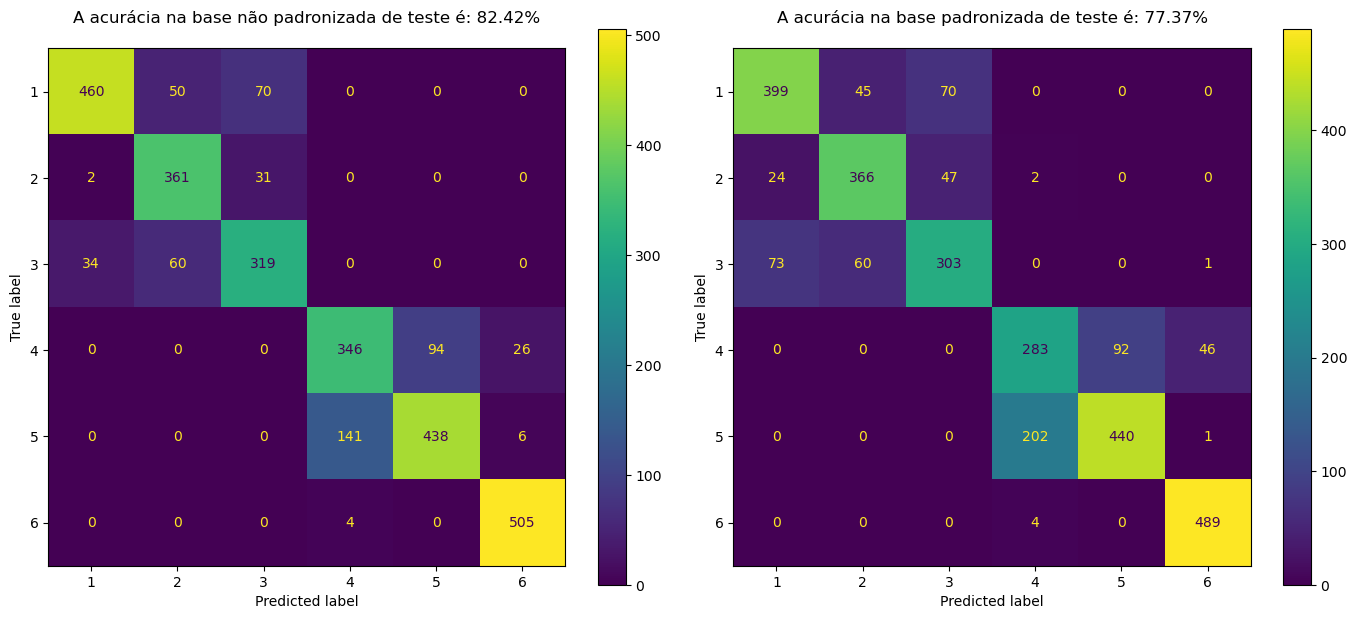

In [79]:
# Faz as predições em cada base 
y_pred = clf.predict(pc_test10)
y_pred_pad = clf_pad.predict(pc_test_pad10)

# Cria as figura onde vão estar os dois gráficos
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Monta a matriz de confusão na base não padronizada e insere o título na figura
ConfusionMatrixDisplay.from_predictions(y_pred, y_test, ax=ax[0])
ax[0].set_title(f'A acurácia na base não padronizada de teste é: {accuracy_score(y_pred, y_test)*100:.2f}%\n')

# Monta a matriz de confusão na base padronizada e insere o título na figura
ConfusionMatrixDisplay.from_predictions(y_pred_pad, y_test, ax=ax[1])
ax[1].set_title(f'A acurácia na base padronizada de teste é: {accuracy_score(y_pred_pad, y_test)*100:.2f}%\n')

# Impede que tenha sobreposição entre título e gráfico
plt.tight_layout()

# Mostra o gráfico
plt.show()